In [100]:
!pip install --upgrade pandas-datareader

You should consider upgrading via the '/Users/nico/PycharmProjects/AIAp-exercises/venv/bin/python -m pip install --upgrade pip' command.


In [101]:
!pip install pandas-datareader yfinance matplotlib scikit-learn numpy tensorflow

You should consider upgrading via the '/Users/nico/PycharmProjects/AIAp-exercises/venv/bin/python -m pip install --upgrade pip' command.


# Reading data

Pandas datareader provides a function get_data_yahoo to directly fetch the stock data of the specified stock from Yahoo Finance for the given duration. WE are extracting the Apple stock price between the duration from 1970-01-01 to 2022-04-25.

In [102]:
import pandas_datareader.data as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
yf.pdr_override()
from datetime import datetime

In [104]:
df_apple = pdr.get_data_yahoo('CSGN.SW', datetime(1970, 1, 1))
df_apple

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-04-14,22.104790,22.104790,22.104790,22.104790,8.429320,0
1995-04-17,22.104790,22.104790,22.104790,22.104790,8.429320,0
1995-05-01,21.325602,21.325602,21.325602,21.325602,8.132190,0
1995-05-16,23.596239,23.596239,23.596239,23.596239,8.998061,0
1995-05-23,23.373589,23.373589,23.373589,23.373589,8.913156,0
...,...,...,...,...,...,...
2023-03-21,0.825000,0.883400,0.786800,0.883400,0.883400,104330133
2023-03-22,0.874800,0.899000,0.821600,0.830800,0.830800,60974085
2023-03-23,0.815400,0.834000,0.796000,0.800800,0.800800,39895221


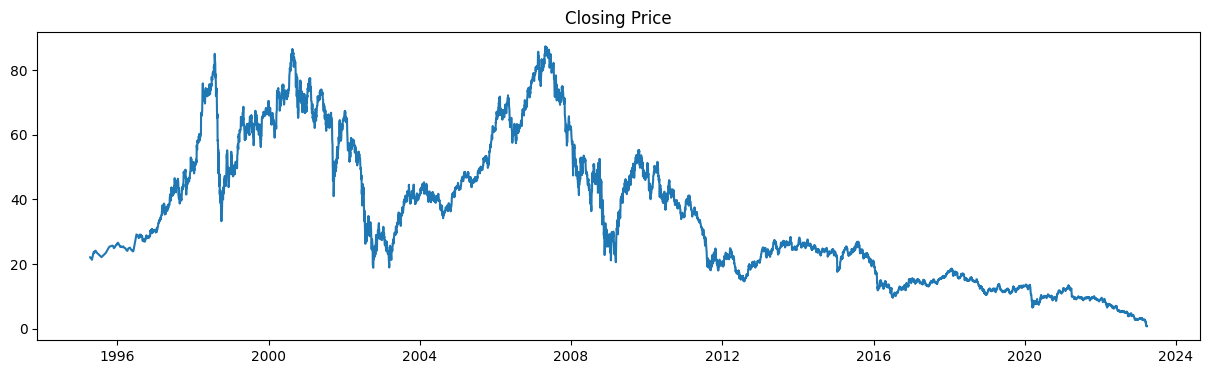

In [105]:
df = df_apple['Close']
plt.figure(figsize = (15,4))
plt.plot(df)
plt.title("Closing Price")
plt.show()

# Dividing the dataset
Since this is time-series data, we cannot use the scikit-learn train_test_split() function because we need to preserve the order of prices. So, we will use, starting 80% of the values as a training dataset and the rest for testing. We also reshaped the datasets to make them compatible for the next step which is normalization. 

In [106]:
last_index = int(len(df) * 0.8)
train_complete = df[:last_index]

last_index_train = int(len(train_complete) * 0.8)
train = train_complete[:last_index_train].values.reshape(-1, 1)
validation = train_complete[last_index_train:].values.reshape(-1, 1)

test = df[last_index:].values.reshape(-1,1)

train.shape, validation.shape, test.shape

((4380, 1), (1095, 1), (1369, 1))

# Normalization
Normalization converts all the values in the range of 0 to 1. It improves convergence and hence reduces training time.

In [107]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
validation = scaler.fit_transform(validation)
test = scaler.transform(test)

train[:10]

array([[0.10240309],
       [0.10240309],
       [0.09168932],
       [0.12291038],
       [0.11984895],
       [0.12750127],
       [0.13056269],
       [0.12291038],
       [0.10301486],
       [0.1206143 ]])

# Splitting the dataset into X and Y
This function specifies how many previous values must be considered to find out the pattern, in order to predict a price. Accordingly, both, the training and testing datasets are split into X and Y.

In [108]:
def create_dataset(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i + time_step), 0]   
    data_X.append(a)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

time_step = 10

X_train, y_train = create_dataset(train, time_step)
X_validation, y_validation = create_dataset(validation, time_step)

X_test, y_test = create_dataset(test, time_step)

In [109]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [116]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, input_shape=[10, 1,]),
    Dense(1)
])
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.build()
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 50)                10400     
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


2023-03-27 16:23:54.937320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 16:23:54.938875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 16:23:54.940502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [117]:
history = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs = 25)

Epoch 1/25


2023-03-27 16:24:18.330077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 16:24:18.331856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 16:24:18.333994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

135/137 [============================>.] - ETA: 0s - loss: 0.0143

2023-03-27 16:24:21.614871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 16:24:21.616862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 16:24:21.618319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

137/137 [==============================] - 4s 10ms/step - loss: 0.0142 - val_loss: 0.0014
Epoch 2/25
137/137 [==============================] - 1s 5ms/step - loss: 7.9177e-04 - val_loss: 0.0014
Epoch 3/25
137/137 [==============================] - 1s 5ms/step - loss: 7.6783e-04 - val_loss: 0.0014
Epoch 4/25
137/137 [==============================] - 1s 6ms/step - loss: 7.2645e-04 - val_loss: 0.0013
Epoch 5/25
137/137 [==============================] - 1s 6ms/step - loss: 7.0466e-04 - val_loss: 0.0013
Epoch 6/25
137/137 [==============================] - 1s 5ms/step - loss: 6.8386e-04 - val_loss: 0.0013
Epoch 7/25
137/137 [==============================] - 1s 6ms/step - loss: 6.5540e-04 - val_loss: 0.0012
Epoch 8/25
137/137 [==============================] - 1s 6ms/step - loss: 6.4093e-04 - val_loss: 0.0011
Epoch 9/25
137/137 [==============================] - 1s 5ms/step - loss: 6.2949e-04 - val_loss: 0.0011
Epoch 10/25
137/137 [==============================] - 1s 6ms/step - loss: 5.7

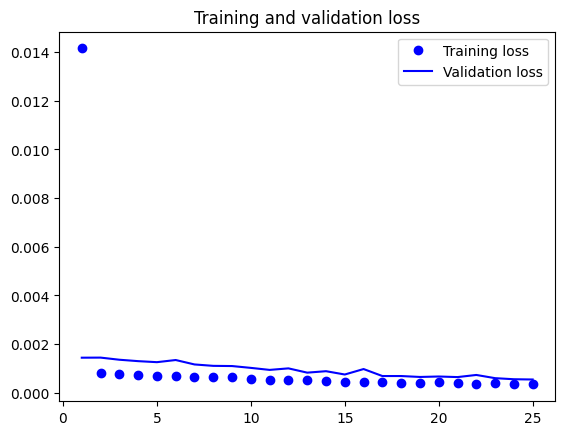

In [118]:
def plot_history(history):
    #acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    #plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.title('Training and validation accuracy')
    #plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_history(history)

In [119]:
test_predict = model.predict(X_test)
test_predict[:10]

2023-03-27 16:24:47.614511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 16:24:47.616102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 16:24:47.617721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - 1s 3ms/step


array([[0.33661014],
       [0.33150214],
       [0.34300843],
       [0.34787142],
       [0.34978163],
       [0.35227904],
       [0.35376394],
       [0.34975946],
       [0.34668416],
       [0.34089303]], dtype=float32)

# Inversing Transformation
Since we normalized the data earlier and converted all the values in the range 0 to 1, now we should inverse the transformation to get actual values. 

In [120]:
test_predict=scaler.inverse_transform(test_predict)

# Visualizing the predictions
Here we have plotted actual and predicted stock prices for the test dataset. We can see that the model is performing fine.

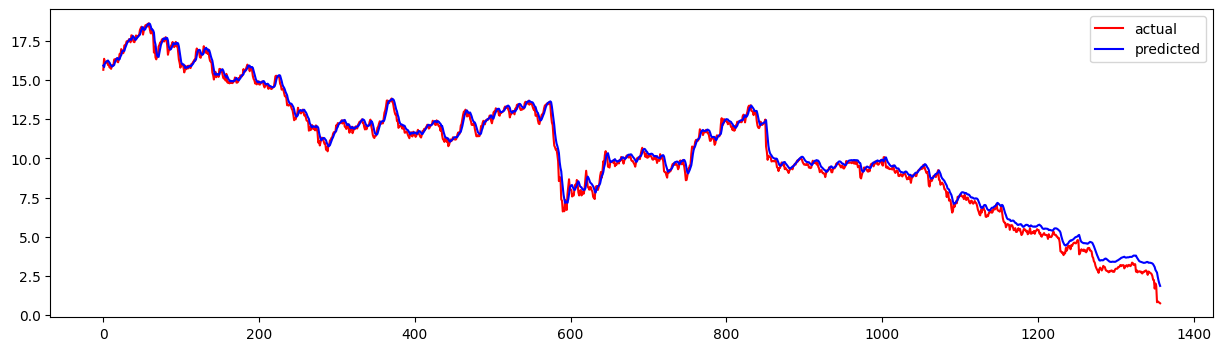

In [121]:
plt.figure(figsize = (15,4))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), color = 'r', label = 'actual')
plt.plot(test_predict, color = 'b',label = 'predicted')
plt.legend()
plt.show()

# Evaluating model
For evaluation, we will be using root mean square values.

In [122]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,test_predict, squared = False)

11.219513751930073